In [1]:
import sys
from pathlib import Path

def in_colab():
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

if in_colab():
    from google.colab import drive
    drive.mount("/content/drive")
    REPO_PATH = Path("/content/drive/My Drive/einstein_program_synthesis/scripts")  # ← adjust if needed
else:
    REPO_PATH = Path.home() / "Documents" / "Code" / "einstein_program_synthesis" / "scripts"  # ← adjust

sys.path.insert(0, str(REPO_PATH.resolve()))
print("Using repo path:", REPO_PATH.resolve())
print("Exists?", REPO_PATH.exists())
print("Contains:", [p.name for p in REPO_PATH.glob("*.py")])


Using repo path: /home/omar/Documents/Code/einstein_program_synthesis/scripts
Exists? True
Contains: ['synthesis_primitives.py', 'einstein_types.py', 'context.py', 'judgments.py', 'typing_rules.py', 'simplify.py', 'bayes_neural_search.py', 'pure_bayes_search.py', 'synthesis_state.py', 'enumeration_search.py']


In [2]:
import importlib
import enumeration_search as es
from einstein_types import Art, Emp

es = importlib.reload(es)
print("module path:", es.__file__)


module path: /home/omar/Documents/Code/einstein_program_synthesis/scripts/enumeration_search.py


In [3]:
es.MAX_SAMPLES  = 200 # 1000
es.CHAIN_LENGTH = 8
es.USE_GREEDY   = False   # True = greedy; False = weighted

es.TERM_WEIGHT  = 0.7
es.TYPE_WEIGHT  = 0.3

es.GOAL_TERM    = "t - u*x/c**2"
es.GOAL_TYPE    = Art & Emp
es.TARGET_TERM  = "f(-k*y + t*w - k*u*x/c)"

es.BACKWARD_NAMES = {"BWD"}

es.ENABLE_NO_REPEAT             = True # False
es.ENABLE_SUB1_CONSTRAINT       = True # False
es.ENABLE_SIM_SIMPUS_CONSTRAINT = True # False
es.ENABLE_SIMPUS_SIM_CONSTRAINT = True # False
es.ENABLE_BACKWARD_GATE         = True # False
es.ENABLE_BACKWARD_ONLY_MODE    = False

es.VERBOSE = True


In [4]:
import cProfile, pstats, io, time

N_RUNS = 150

t0 = time.perf_counter()
pr = cProfile.Profile(); pr.enable()

results = es.run_experiments(
    N_RUNS,
    max_samples=es.MAX_SAMPLES,
    parallel=False
)

pr.disable()
s = io.StringIO()
pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime").print_stats(20)
print("\n=== PROFILING RESULTS ===")
print(s.getvalue())

t1 = time.perf_counter()
print(f"\n✅ Total elapsed time: {t1 - t0:.2f} seconds")


Run   1: ❌ not reached
Run   2: ✅ reached at chain 112
Run   3: ✅ reached at chain 104
Run   4: ❌ not reached
Run   5: ❌ not reached
Run   6: ✅ reached at chain 195
Run   7: ✅ reached at chain 196
Run   8: ✅ reached at chain 200
Run   9: ❌ not reached
Run  10: ✅ reached at chain 115
Run  11: ❌ not reached
Run  12: ❌ not reached
Run  13: ❌ not reached
Run  14: ✅ reached at chain 165
Run  15: ❌ not reached
Run  16: ❌ not reached
Run  17: ✅ reached at chain 62
Run  18: ❌ not reached
Run  19: ❌ not reached
Run  20: ✅ reached at chain 45
Run  21: ❌ not reached
Run  22: ✅ reached at chain 23
Run  23: ✅ reached at chain 130
Run  24: ✅ reached at chain 95
Run  25: ✅ reached at chain 99
Run  26: ❌ not reached
Run  27: ❌ not reached
Run  28: ✅ reached at chain 47
Run  29: ❌ not reached
Run  30: ✅ reached at chain 147
Run  31: ✅ reached at chain 102
Run  32: ❌ not reached
Run  33: ✅ reached at chain 128
Run  34: ✅ reached at chain 84
Run  35: ✅ reached at chain 171
Run  36: ❌ not reached
Run  37:

In [17]:
success_indices_enum = [r for r in results if r is not None]
print("All program-indices at which the goal was met:")
print(success_indices_enum)


All program-indices at which the goal was met:
[112, 104, 195, 196, 200, 115, 165, 62, 45, 23, 130, 95, 99, 47, 147, 102, 128, 84, 171, 88, 144, 139, 173, 78, 190, 154, 90, 57, 164, 134, 74, 46, 169, 197, 9, 73, 87, 139, 68, 52, 37, 49, 117, 49, 119, 62, 62, 162, 114, 155, 63, 154, 161, 95, 157, 173, 136, 140, 199, 189, 189, 24, 172, 112, 53, 200, 80, 123, 185, 82, 112, 190, 89, 147, 171]


In [18]:
import numpy as np
arr = np.array(success_indices_enum, dtype=float)
if arr.size:
    print({
        "n": int(arr.size),
        "mean": float(arr.mean()),
        "std": float(arr.std(ddof=1)) if arr.size > 1 else 0.0,
        "median": float(np.median(arr)),
        "q25": float(np.quantile(arr, 0.25)),
        "q75": float(np.quantile(arr, 0.75)),
        "p90": float(np.percentile(arr, 90)),
        "p95": float(np.percentile(arr, 95)),
        "min": float(arr.min()),
        "max": float(arr.max()),
    })
else:
    print("no successful runs in this batch.")

{'n': 75, 'mean': 118.22666666666667, 'std': 52.261187431130104, 'median': 117.0, 'q25': 76.0, 'q75': 163.0, 'p90': 189.60000000000002, 'p95': 196.3, 'min': 9.0, 'max': 200.0}


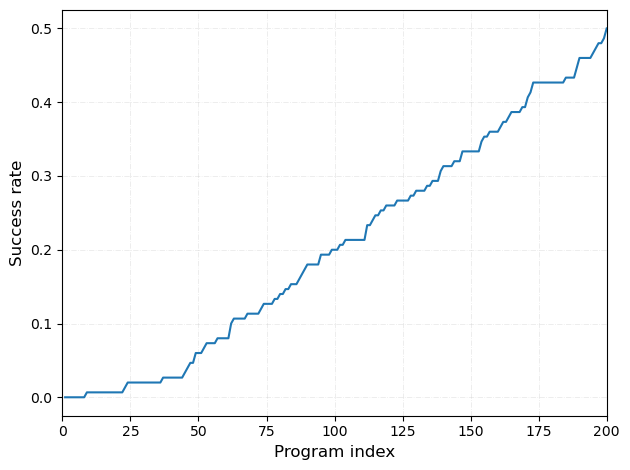

In [19]:
import numpy as np, matplotlib.pyplot as plt
xmax = es.MAX_SAMPLES
x = np.arange(1, xmax + 1)
succ = np.array(success_indices_enum, dtype=int)
rate = np.array([(succ <= k).sum() for k in x]) / max(len(results), 1)

plt.figure()
plt.plot(x, rate)
plt.xlabel("Program index", fontsize=12)
plt.ylabel("Success rate", fontsize=12)
plt.xlim(0, xmax)
plt.grid(True, color="#CCCCCC", linewidth=0.6, linestyle='-.', alpha=0.4)
plt.tight_layout()
plt.show()

In [20]:
es.expr_to_str.cache_clear()